# Testing PCA Class

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
from PCA import PCA
from scipy.interpolate import interp1d
from LeastSquares import LeastSquares
%matplotlib notebook 

In [2]:
freq = [0.01, 0.022, 0.045, 0.408, 1.42,2.326] #6 frequencies
freq_arr = (np.array(freq)).reshape(len(freq),1) #creating freq array (6x1)
pca = PCA(freq) #object of PCA class
ls = LeastSquares(freq_arr) #object of LeastSquares class

clean_matrix,clean_dict = pca.data_matrix('all_data.npz') #data matrix for clean data
noisy_matrix,noisy_dict = pca.data_matrix('noisy_data_new.npz') #data matrix for noisy data
blur_matrix,blur_dict = pca.data_matrix('blurry_data_new.npz') #data matrix for blurred data
blur_noisy_matrix,blur_noisy_dict = pca.data_matrix('blurry_noisy_data_new.npz') #data matrix for blurred noisy data

#data from different part of sky (more in galactic plane)
diff_matrix,diff_dict = pca.data_matrix('diff_data.npz') #data matrix from diff part of sky 
diffnoisy_matrix,diffnoisy_dict = pca.data_matrix('diff_noisy_data.npz') #noisy data
diffblur_matrix,diffblur_dict = pca.data_matrix('diff_blurry_data.npz') #blurred data 
diffblur_noisy_matrix,diffblur_noisy_dict = pca.data_matrix('diff_blurry_noisy_data.npz') #blurred noisy data

#data blurred systematically (lower frequencies blurred more than higher frequencies)
diffblur_matrix2,diffblur_dict2 = pca.data_matrix('diff_blurry_data_2.npz') #blurred data 
diffblur_noisy_matrix2,diffblur_noisy_dict2 = pca.data_matrix('diff_blurry_noisy_data_2.npz') #blurred noisy data

## Dividing Spectra by Average (Power Law)

Using the <strong>LeastSquares</strong> class, I fitted the average of the spectra to a power law. Then, I divided the whole spectra by that power law to create a more flattened curve. The <strong>ymodel</strong> function for the power law returns the y model or <strong>pow_freq_fit</strong> in the form 

$$\bar{y} = \begin{bmatrix}
log(y_{1}) \\
log(y_{2}) \\
\vdots \\
\end{bmatrix}$$

Since it is the log of the y values, I took the exponential of that log (line 6) to get the actual y value. With that, I don't need to graph the new spectra on a log-log graph.

In [3]:
freq_pow = ls.pow_matrix() #data matrix for power law model
mean_y = np.mean(clean_matrix, axis = 0) #mean of clean spectra
log_mean_y = (np.log(mean_y)).reshape(mean_y.shape[0],1) #log of mean and reshaping (6x1)

pow_freq_fit, pow_freq_param, pow_error = ls.ymodel(freq_pow, log_mean_y) #fit for model (y values), parameters, error
fit_y = np.exp(pow_freq_fit) #taking exponential of pow_freq_fit to get y value

In [4]:
num_rows = clean_matrix.shape[0] #number of rows of clean matrix
num_col = clean_matrix.shape[1] #number of columns of clean matrix
avg_clean_matrix = np.zeros((num_rows,num_col)) #creating empty array to store values

for i in np.arange(num_rows):
    #dividing each row of clean matrix by average data 
    avg_clean_matrix[i] = np.divide(clean_matrix[i].reshape(1,num_col),fit_y.reshape(1,num_col)) #storing it in avg_clean_matrix
    
avg_clean_dict = dict(zip(freq,(avg_clean_matrix[:,i] for i in range(avg_clean_matrix.shape[0])))) 

## Determining Eigenvalues and Eigenvectors

In [5]:
cov,stand_matrix = pca.cov_matrix(clean_matrix) #covariance and standardized data for clean matrix
noisy_cov,noisy_stand_matrix = pca.cov_matrix(noisy_matrix) #covariance of noisy data
avg_cov,s = pca.cov_matrix(avg_clean_matrix) #covariance for spectra divided by the average

corr = pca.corr_matrix(clean_matrix) #correlation matrix

#finding covariance and standardized data for diff_matrix (from different part of sky)
diff_cov, diff_stand_matrix = pca.cov_matrix(diff_matrix) 
diffblur_cov, diff_stand_matrix2 = pca.cov_matrix(diffblur_matrix) 
diffblur_cov2, diff_stand_matrix3 = pca.cov_matrix(diffblur_matrix2) #blurred systematically

#finding eigenvalues and eigenvectors

#clean matrix
eigval,eigvec,eigpairs = pca.eig_values(cov)
eigval_dict = pca.ordered_eigval(eigval)

#noisy data
noisy_eigval,noisy_eigvec,noisy_eigpairs = pca.eig_values(noisy_cov)
noisy_eigval_dict = pca.ordered_eigval(noisy_eigval)

#data divided by average
divavg_eigval,divavg_eigvec,divavg_eigpairs = pca.eig_values(avg_cov)
divavg_eigval_dict = pca.ordered_eigval(divavg_eigval)

#correlation
corr_eigval,corr_eigvec,corr_eigpairs = pca.eig_values(corr)
corr_eigval_dict = pca.ordered_eigval(corr_eigval)

#diff matrix (from part of sky)
diff_eigval,diff_eigvec,diff_eigpairs = pca.eig_values(diff_cov)
diff_eigval_dict = pca.ordered_eigval(diff_eigval)

#blurred diff matrix
diffblur_eigval,diffblur_eigvec,diffblur_eigpairs = pca.eig_values(diffblur_cov)
diffblur_eigval_dict = pca.ordered_eigval(diffblur_eigval)

#blurred systematically diff matrix
diffblur_eigval2,diffblur_eigvec2,diffblur_eigpairs2 = pca.eig_values(diffblur_cov2)
diffblur_eigval_dict2 = pca.ordered_eigval(diffblur_eigval2)

## Plotting Eigenvalues and Eigenvectors

<IPython.core.display.Javascript object>


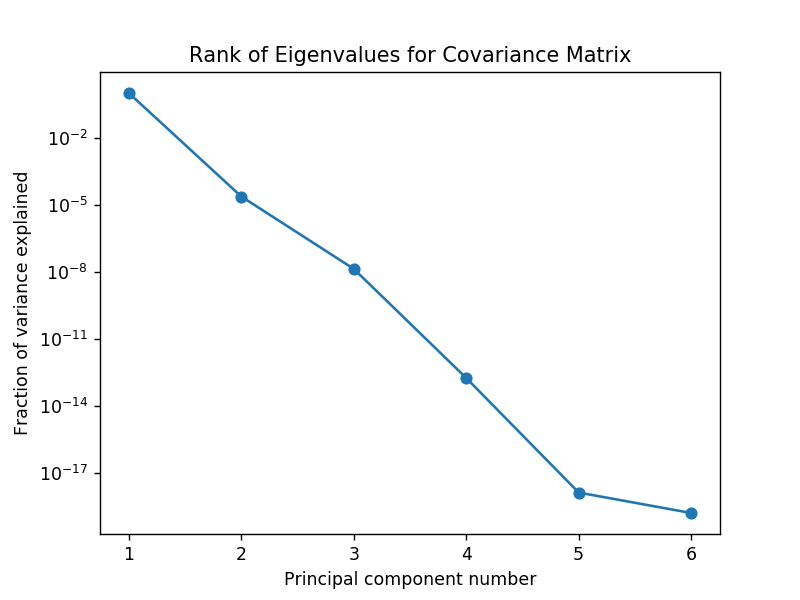

<IPython.core.display.Javascript object>


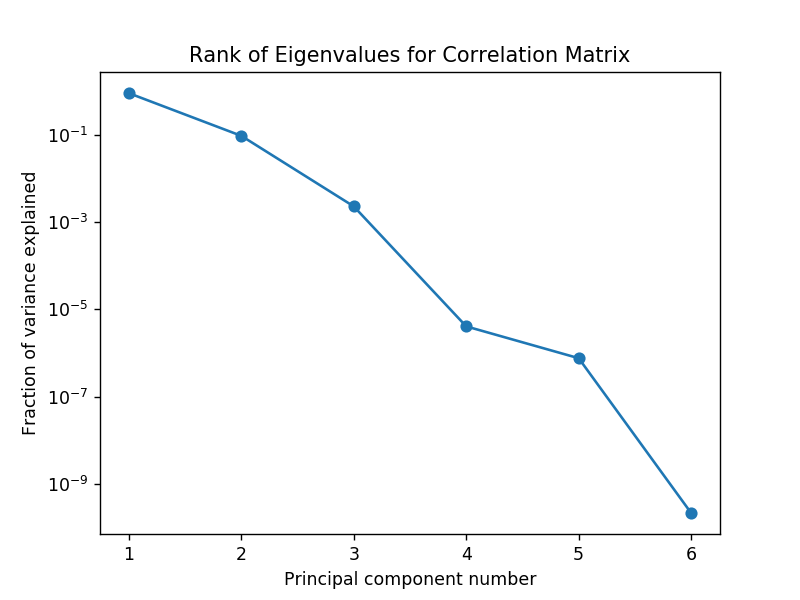

<IPython.core.display.Javascript object>


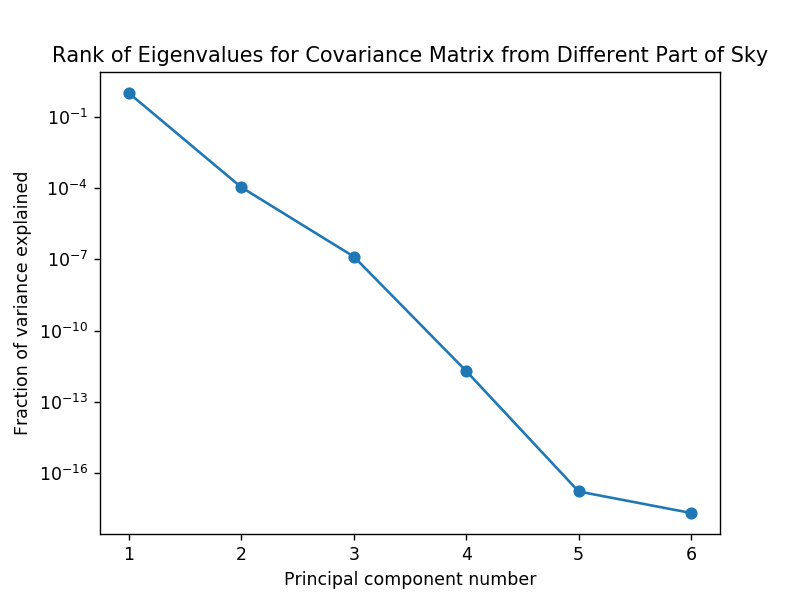

<IPython.core.display.Javascript object>


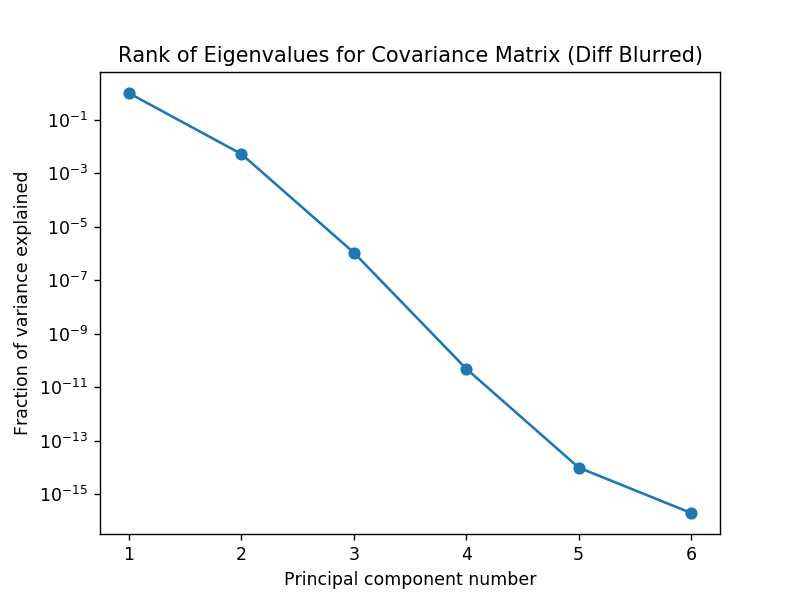

<IPython.core.display.Javascript object>


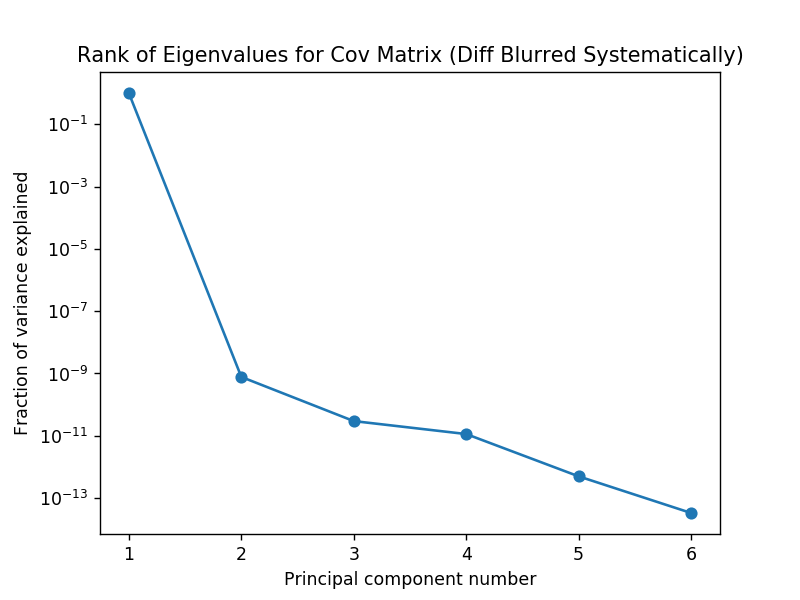

In [6]:
pca.graph_eigval('Rank of Eigenvalues for Covariance Matrix',eigval_dict)
pca.graph_eigval('Rank of Eigenvalues for Correlation Matrix',corr_eigval_dict)
pca.graph_eigval('Rank of Eigenvalues for Covariance Matrix from Different Part of Sky',diff_eigval_dict)
pca.graph_eigval('Rank of Eigenvalues for Covariance Matrix (Diff Blurred)',diffblur_eigval_dict)
pca.graph_eigval('Rank of Eigenvalues for Cov Matrix (Diff Blurred Systematically)',diffblur_eigval_dict2)
# pca.graph_eigval('Rank of Eigenvalues for Data Divided by Average',eigval_dict3)
# pca.graph_eigval('Rank of Eigenvalues for Noisy Covariance Matrix',eigval_dict4)

<IPython.core.display.Javascript object>


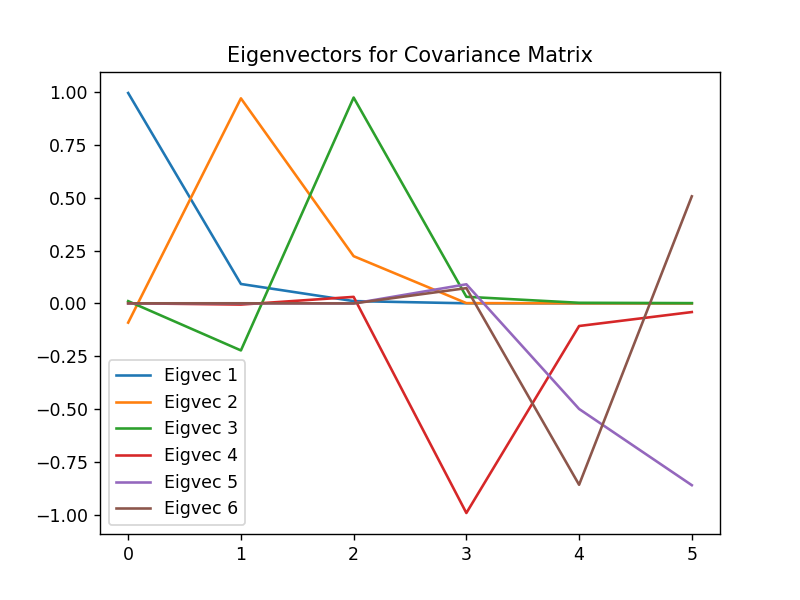

<IPython.core.display.Javascript object>


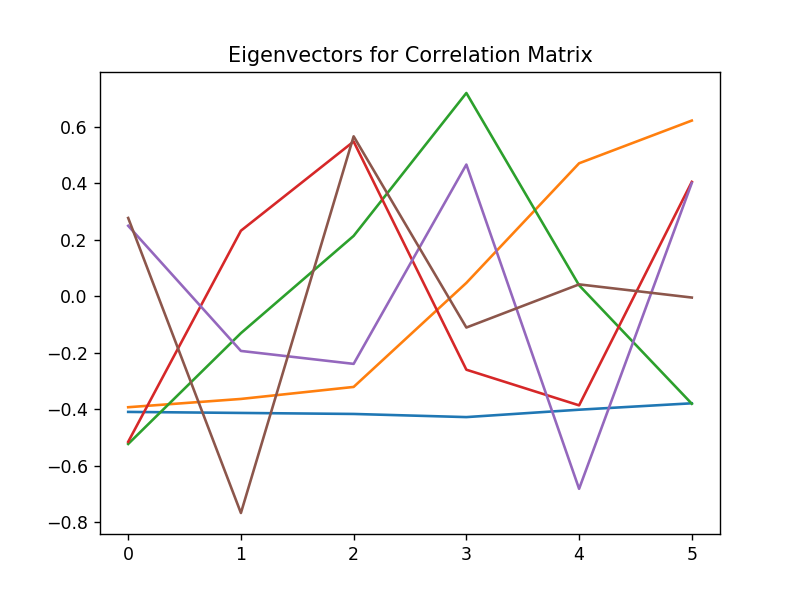

In [7]:
plt.figure()
plt.title('Eigenvectors for Covariance Matrix')
legend_arr = []
for i in np.arange(eigvec.shape[1]):
    plt.plot(eigvec[:,i])
    legend_arr.append('Eigvec '+ str(i+1))
#     plt.quiver([0,0],*eigvec[:,i],scale=1.15,color='b')
plt.legend(legend_arr,loc='lower left')
plt.show()

plt.figure()
plt.title('Eigenvectors for Correlation Matrix')
for i in np.arange(corr_eigvec.shape[1]):
    plt.plot(corr_eigvec[:,i])
#     plt.quiver([0,0],*eigvec2[:,i],scale=1.15,color='orange')
plt.show()

## Testing Principal Component Fits

We can write the spectra as a linear combination of the eigenvectors so that
$$\vec{s} = a_{1}\vec{v_{1}} + a_{2}\vec{v_{3}} + a_{3}\vec{v_{3}} +\ldots= \sum_{i}^{p}{a_{i}\vec{v_{i}}} $$
where $ \{a_{1},a_{2},\ldots\} $ is the expansion coefficient. Through this, we form a different basis with the eigenvectors. 

Now, how do we find the coefficients? We can rewrite this in matrix form where the spectra $S$ is a $nxp$ matrix so that
$$S = \begin{bmatrix}
    a_{1} \\
    a_{2} \\
    \vdots \\
    a_{n} \\
    \end{bmatrix} * [\vec{v_{1}} \vec{v_{2}} \ldots \vec{v_{p}}]$$
    
This looks similar to a least squares problem where we are trying to find the parameters, or, in this case, the coefficients for the eigenvectors. Using this reasoning, I used the <strong>ymodel</strong> function from the <strong>LeastSquares</strong> class which returns the values for the fit, parameters, and the error covariance. Since the <strong>ymodel</strong> function already returns the new fit based on the principal components, I didn't need to recalculate it using the coefficients and eigenvectors.

In [21]:
total_fit,total_coef,total_err = ls.ymodel(eigvec,clean_matrix.T) #fit for all principal components (pc)
one_fit,one_coef,one_err = ls.ymodel(eigvec[:,0].reshape(eigvec.shape[0],1),clean_matrix.T) #first pc
two_fit,two_coef,two_err = ls.ymodel(eigvec[:,:2].reshape(eigvec.shape[0],2),clean_matrix.T) #first two pc

#different data (from diff part of sky)
diff_total_fit,diff_total_coef,diff_total_err = ls.ymodel(diff_eigvec,diff_matrix.T) 
diff_one_fit,diff_one_coef,diff_one_err = ls.ymodel(diff_eigvec[:,0].reshape(diff_eigvec.shape[0],1),diff_matrix.T) 
diff_two_fit,diff_two_coef,diff_two_err = ls.ymodel(diff_eigvec[:,:2].reshape(diff_eigvec.shape[0],2),diff_matrix.T) 

#different blurred data (from diff part of sky)
diffblur_total_fit,diff_total_coef2,diff_total_err2 = ls.ymodel(diffblur_eigvec,diffblur_matrix.T) 
diffblur_one_fit,diff_one_coef2,diff_one_err2 = ls.ymodel(diffblur_eigvec[:,0].reshape(diffblur_eigvec.shape[0],1),diffblur_matrix.T)  
diffblur_two_fit,diff_two_coef2,diff_two_err2 = ls.ymodel(diffblur_eigvec[:,:2].reshape(diffblur_eigvec.shape[0],2),diffblur_matrix.T)

#different data blurred systematically (from diff part of sky)
diffblur_total_fit2,diff_total_coef3,diff_total_err3 = ls.ymodel(diffblur_eigvec2,diffblur_matrix2.T) 
diffblur_one_fit2,diff_one_coef3,diff_one_err3 = ls.ymodel(diffblur_eigvec2[:,0].reshape(diffblur_eigvec2.shape[0],1),diffblur_matrix2.T) 
diffblur_two_fit2,diff_two_coef3,diff_two_err3 = ls.ymodel(diffblur_eigvec2[:,:2].reshape(diffblur_eigvec2.shape[0],2),diffblur_matrix2.T) 

In the graphs, I plotted the fit for the principal components using different amounts of the principal componenets: all of the principal components, the first principal component, and the first two prinicpal components. 

<IPython.core.display.Javascript object>


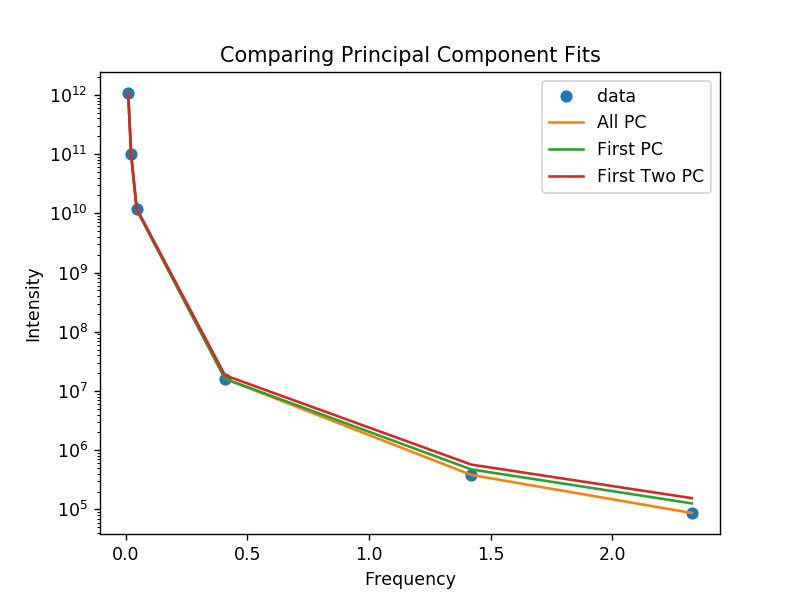

<IPython.core.display.Javascript object>


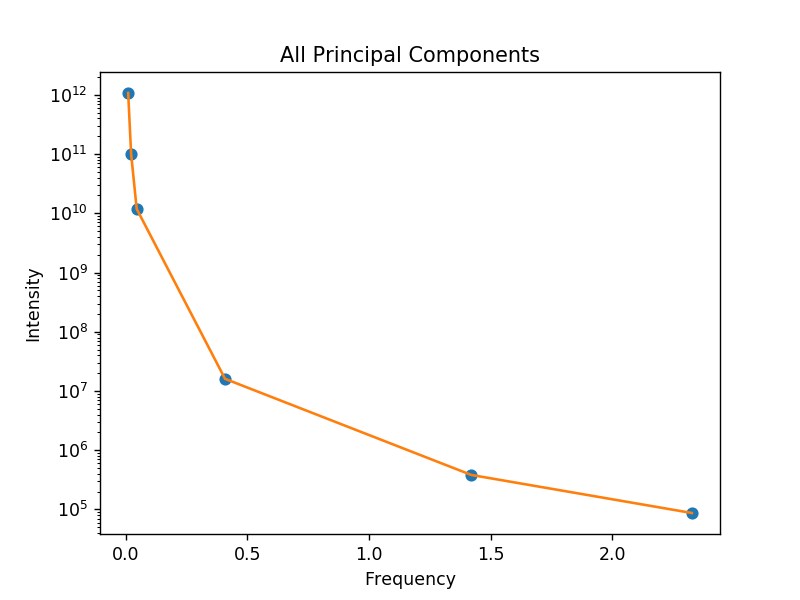

<IPython.core.display.Javascript object>


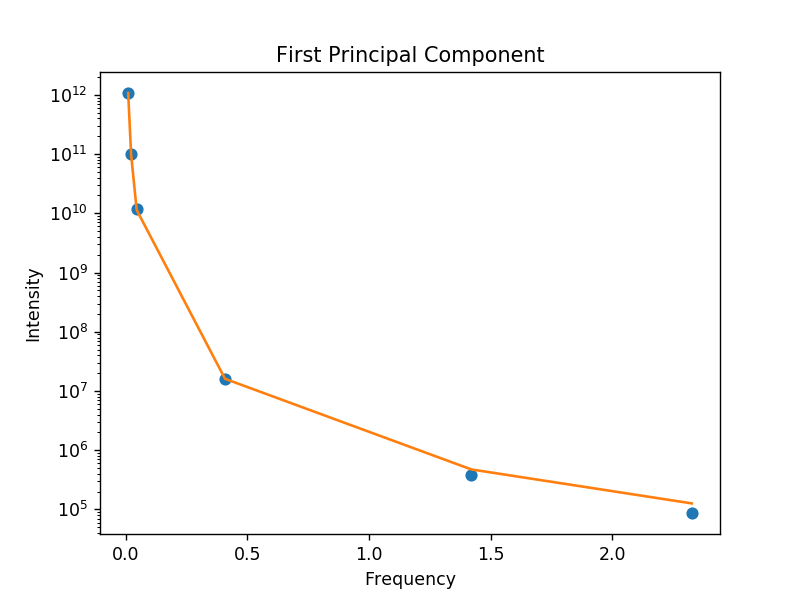

<IPython.core.display.Javascript object>


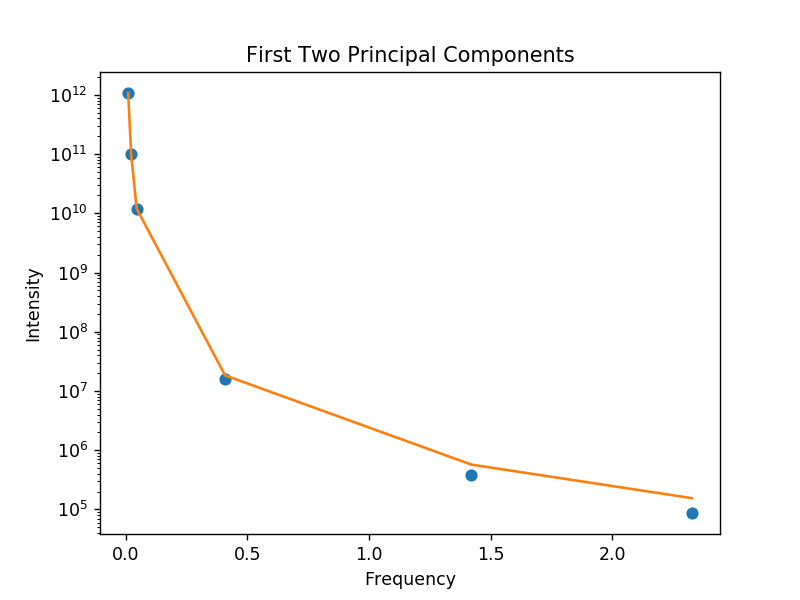

<IPython.core.display.Javascript object>


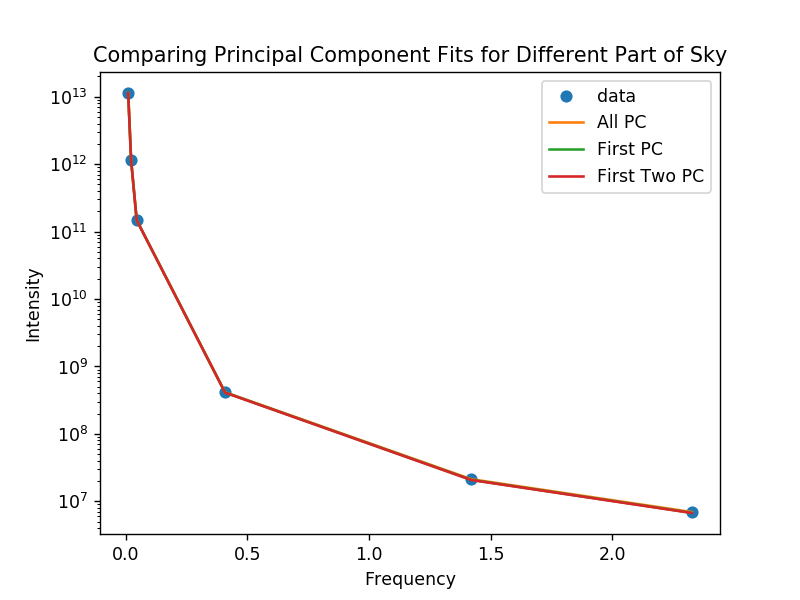

<IPython.core.display.Javascript object>


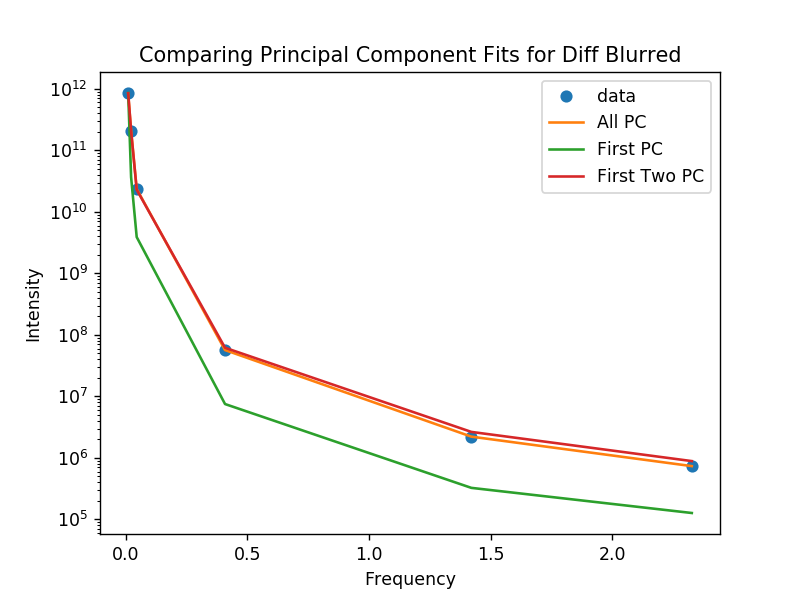

<IPython.core.display.Javascript object>


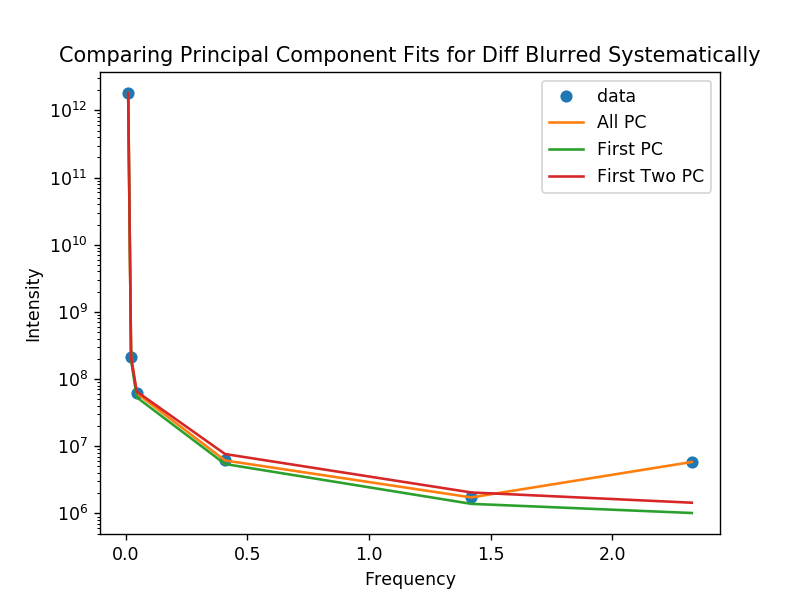

In [29]:
pixel = 130000

plt.figure()
plt.yscale('log')
plt.xlabel('Frequency')
plt.ylabel('Intensity')
plt.title('Comparing Principal Component Fits')
plt.plot(freq,clean_matrix[pixel],'o',freq,total_fit[:,pixel],'-',freq,one_fit[:,pixel],'-',freq,two_fit[:,pixel],'-')
plt.legend(['data','All PC','First PC','First Two PC'],loc='upper right')

plt.figure()
plt.yscale('log')
plt.xlabel('Frequency')
plt.ylabel('Intensity')
plt.title('All Principal Components')
plt.plot(freq,clean_matrix[pixel],'o',freq,total_fit[:,pixel],'-')

plt.figure()
plt.yscale('log')
plt.xlabel('Frequency')
plt.ylabel('Intensity')
plt.title('First Principal Component')
plt.plot(freq,clean_matrix[pixel],'o',freq,one_fit[:,pixel],'-')

plt.figure()
plt.yscale('log')
plt.xlabel('Frequency')
plt.ylabel('Intensity')
plt.title('First Two Principal Components')
plt.plot(freq,clean_matrix[pixel],'o',freq,two_fit[:,pixel],'-')

pixel2 = 50000
plt.figure()
plt.yscale('log')
plt.xlabel('Frequency')
plt.ylabel('Intensity')
plt.title('Comparing Principal Component Fits for Different Part of Sky')
plt.plot(freq,diff_matrix[pixel2],'o',freq,diff_total_fit[:,pixel2],'-',
         freq,diff_one_fit[:,pixel2],'-',freq,diff_two_fit[:,pixel2],'-')
plt.legend(['data','All PC','First PC','First Two PC'],loc='upper right')

plt.figure()
plt.yscale('log')
plt.xlabel('Frequency')
plt.ylabel('Intensity')
plt.title('Comparing Principal Component Fits for Diff Blurred')
plt.plot(freq,diffblur_matrix[pixel2],'o',freq,diffblur_total_fit[:,pixel2],'-',
         freq,diffblur_one_fit[:,pixel2],'-',freq,diffblur_two_fit[:,pixel2],'-')
plt.legend(['data','All PC','First PC','First Two PC'],loc='upper right')

plt.figure()
plt.yscale('log')
plt.xlabel('Frequency')
plt.ylabel('Intensity')
plt.title('Comparing Principal Component Fits for Diff Blurred Systematically')
plt.plot(freq,diffblur_matrix2[pixel2],'o',freq,diffblur_total_fit2[:,pixel2],'-',
         freq,diffblur_one_fit2[:,pixel2],'-',freq,diffblur_two_fit2[:,pixel2],'-')
plt.legend(['data','All PC','First PC','First Two PC'],loc='upper right')

## Cubic Spline Interpolation

Interpolation is the estimation of a value within a set of data points. The estimated curve passes through all the given points. Spline interpolation is a type of interpolation where the interpolant is a piecewise polynomial known as the spline. The cubic spline is the smoothest while also being the lowest degree. It also avoids the Runge's phenomenon where when interpolating with higher degrees can result in unexpected oscillations. 

In [10]:
xnew = np.linspace(0.01,2.326,100) #freq values to be interpolated from
xnew_log = np.log(xnew) #log of xnew
freq_log = np.log(freq) #log of freq
clean_matrix_log = np.log(clean_matrix[pixel]) #log of intensity
inter_onefit_log = interp1d(freq_log, np.log(one_fit[:,pixel])) #interpolate log of freq and y fit for one eigvec
inter_twofit_log = interp1d(freq_log, np.log(two_fit[:,pixel])) #interpolate log of freq and y fit for first two eigvec

<IPython.core.display.Javascript object>


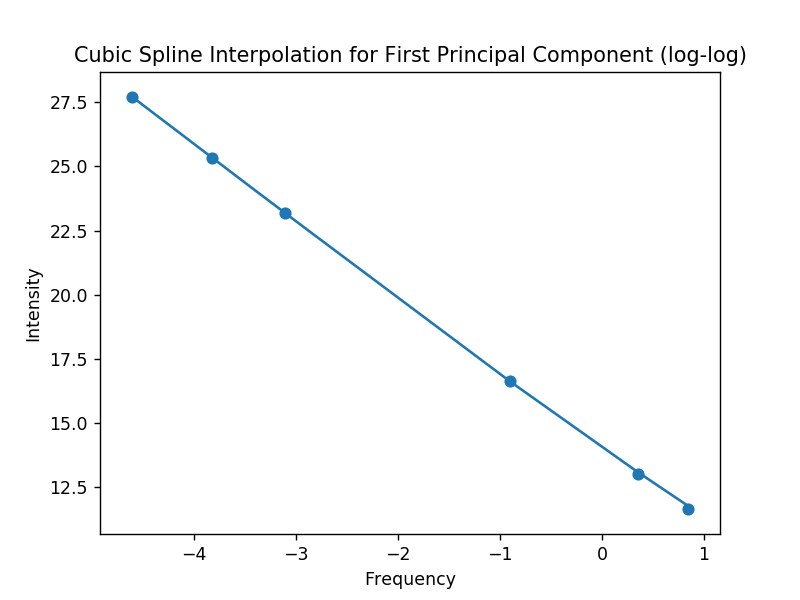

<IPython.core.display.Javascript object>


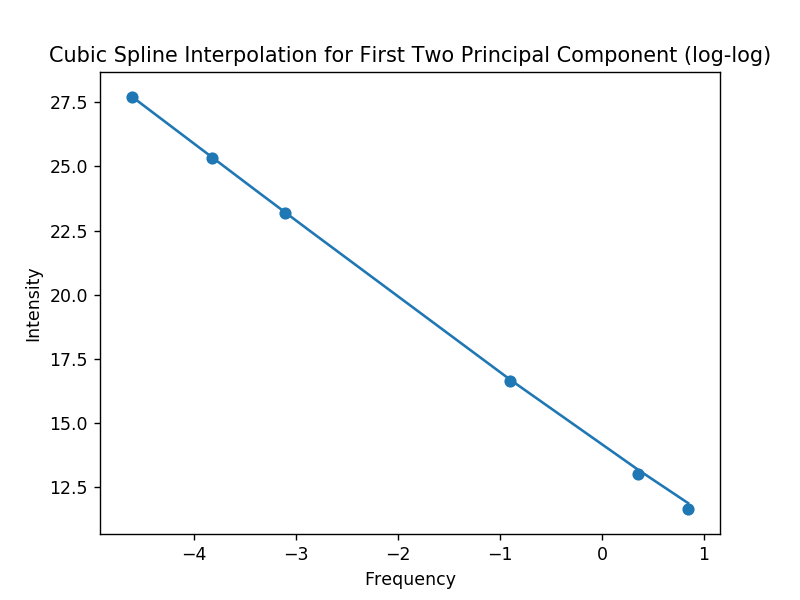

Text(0.5, 1.0, 'Cubic Spline Interpolation for First Two Principal Component (log-log)')

In [11]:
plt.figure()
plt.plot(xnew_log,inter_onefit_log(xnew_log)) #log of interpolated plot for one pc
plt.scatter(freq_log,clean_matrix_log) #log of data
plt.xlabel('Frequency')
plt.ylabel('Intensity')
plt.title('Cubic Spline Interpolation for First Principal Component (log-log)')

plt.figure()
plt.plot(xnew_log,inter_twofit_log(xnew_log)) #log of interpolated plot for first two pc
plt.scatter(freq_log,clean_matrix_log) #log of data
plt.xlabel('Frequency')
plt.ylabel('Intensity')
plt.title('Cubic Spline Interpolation for First Two Principal Component (log-log)')

With interp1d, you can also extrapolate the data outside of the range of the interpolation function. In <strong>f2</strong>, I interpolated the data starting from the second element (index 1) for both the frequency and intensity values. Then, I substituted in the interpolation function a frequency range outside of the range (<strong>xnew2</strong>) of the interpolation. To test the accuracy, I purposely excluded the first data point from the interpolation function which is graphed on the scatter plot (left-most point) below.

<IPython.core.display.Javascript object>


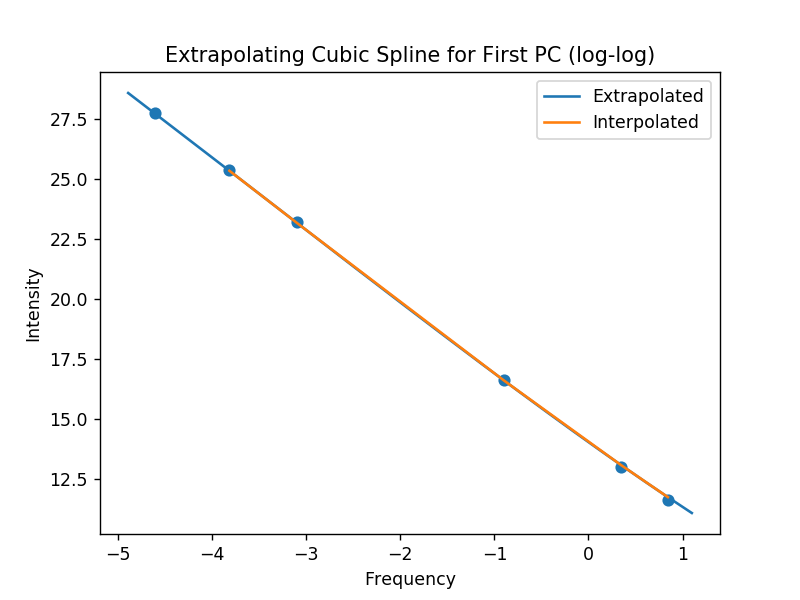

Text(0.5, 1.0, 'Extrapolating Cubic Spline for First PC (log-log)')

In [12]:
f2 = interp1d(freq_log[1:],np.log(one_fit[:,pixel])[1:],kind = 'cubic',fill_value = 'extrapolate',bounds_error=False) #creates interpolate function 
xnew2 = np.linspace(0.0075,3,200) #freq values outside of interpolated range
xnew2_log = np.log(xnew2) 
plt.figure()
plt.plot(xnew2_log,f2(xnew2_log)) #extrapolated plot
plt.plot(freq_log[1:],np.log(one_fit[:,pixel])[1:]) #interpolated
plt.scatter(freq_log,clean_matrix_log)
plt.xlabel('Frequency')
plt.ylabel('Intensity')
plt.legend(['Extrapolated','Interpolated'],loc='upper right')
plt.title('Extrapolating Cubic Spline for First PC (log-log)')

In [13]:
inter_eig1 = interp1d(freq,eigvec[:,0], kind = 'cubic') #interpolation of first eigenvector
inter_eig2 = interp1d(freq,eigvec[:,1], kind = 'cubic') #interpolation of second eigenvector
inter_eig12 = np.hstack([inter_eig1(xnew).reshape(100,1),inter_eig2(xnew).reshape(100,1)]) #combining both (100x2)
ynew2 = np.dot(two_coef.T,inter_eig12.T) #multipying coefficients w/inter_eig12 (163860x100)

ynew1 = np.dot(one_coef.T,(inter_eig1(xnew).reshape(100,1)).T) #interpolation for first eigenvector
f1_log = interp1d(freq_log,np.log(clean_matrix[pixel]),kind = 'cubic') #creates interpolate function 

#data from different part of sky
diff_intereig1 = interp1d(freq,diff_eigvec[:,0]) #interpolation of first eigenvector
diff_intereig2 = interp1d(freq,diff_eigvec[:,1]) #interpolation of second eigenvector
diff_intereig12 = np.hstack([diff_intereig1(xnew).reshape(100,1),diff_intereig2(xnew).reshape(100,1)]) #combining both (100x2)
diff_ynew2 = np.dot(diff_two_coef.T,diff_intereig12.T) #multipying coefficients w/inter_eig12 (163860x100)

<IPython.core.display.Javascript object>


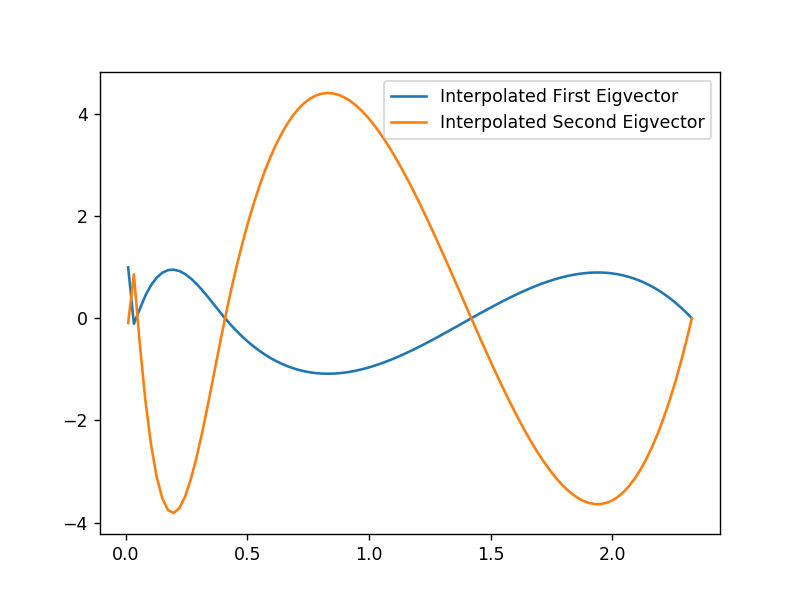

In [14]:
plt.figure()
plt.plot(xnew,inter_eig1(xnew))
plt.plot(xnew,inter_eig2(xnew))
plt.legend(['Interpolated First Eigvector','Interpolated Second Eigvector'],loc='upper right')

## Comparing Power Slope from Clean Data and Blurred Data

In [15]:
clean_pow_slope = np.zeros(clean_matrix.shape[0]) #array of power slopes for clean data
blur_pow_slope = np.zeros(blur_matrix.shape[0]) #array of power slopes for smooth data

# for i in np.arange(clean_matrix.shape[0]):
#     log_clean = (np.log(clean_matrix[i])).reshape(clean_matrix.shape[1],1) #taking log of row of matrix
#     p,param,er = ls.ymodel(freq_pow,log_clean)
#     clean_pow_slope[i] = param[1] 
# # smooth_matrix
# for i in np.arange(blur_matrix.shape[0]):
#     log_blur = (np.log(blur_matrix[i])).reshape(blur_matrix.shape[1],1)
#     p,param,er = ls.ymodel(freq_pow,log_blur)
#     blur_pow_slope[i] = param[1]

In [16]:
print(clean_pow_slope)
print('\n',blur_pow_slope)

[0. 0. 0. ... 0. 0. 0.]

 [0. 0. 0. ... 0. 0. 0.]


## Plotting Spectra

In [17]:
# %%time

# plt.figure()
# plt.plot(list(clean_dict.keys()),list(clean_dict.values()))
# plt.plot(freq,fit_y,linewidth = 3, color = 'black')
# plt.yscale('log')
# plt.xlabel('Frequency')
# plt.ylabel('Intensity')
# plt.title('Spectra')
# plt.show()

In [18]:
# %%time

# plt.figure()
# plt.plot(list(noisy_dict.keys()),list(noisy_dict.values()))
# plt.yscale('log')
# plt.title('Noisy')
# plt.show()

In [19]:
# %%time 

# plt.figure()
# plt.plot(list(avg_clean_dict.keys()),list(avg_clean_dict.values()))
# plt.title('Divided Clean by Average (power law)')
# plt.show()

In [20]:
# %%time

# plt.figure()
# plt.plot(list(blur_dict.keys()),list(blur_dict.values()))
# plt.yscale('log')
# plt.title('Smooth')
# plt.show()